In [1]:
!pip install pandas scikit-learn optuna statsmodels scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import optuna
import os
import logging
from include.utils import incrementar_dados_aleatorios_csv, limpar_dados, categorizar_imc, check_modelo_nan_inf
from include.utils import prever_encargos_futuros, segmentacao_de_risco, analise_de_sensibilidade, otimizacao_de_recursos, planejamento_estrategico

In [3]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

**1. Engenharia de Recursos**

Novos recursos derivados dos dados existentes

In [4]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

# Carregar os dados processados
X_train = pd.read_csv('../planilhas/3_dados_processados_treino.csv', encoding='latin-1')
X_test = pd.read_csv('../planilhas/4_dados_processados_teste.csv', encoding='latin-1')
y_train = pd.read_csv('../planilhas/5_dados_processados_treino_target.csv', encoding='latin-1')
y_test = pd.read_csv('../planilhas/6_dados_processados_teste_target.csv', encoding='latin-1')

# Converter y_train em um array unidimensional
y_train = y_train.values.ravel()

# Converter y_test em um array unidimensional
y_test = y_test.values.ravel()

# Descarto na predição do modelo, mas trago novamente nos dados futuros
colunas_descartadas_treino = X_train[['Gênero','Região','Categoria_IMC']]
colunas_descartadas_teste = X_test[['Gênero','Região','Categoria_IMC']]
X_train = X_train.drop(colunas_descartadas_treino, axis=1)
X_test = X_test.drop(colunas_descartadas_teste, axis=1)

**2. Limpeza de Dados**

In [5]:
X_train = limpar_dados(X_train)
X_test = limpar_dados(X_test)

In [6]:
print("\nQuantidade de valores ausentes por coluna:\n\n", X_train.isnull().sum())
print(f"\nQuantidade de linhas: {X_train.shape[0]}. Quantidade de colunas: {X_train.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade      0
IMC        0
Filhos     0
Fumante    0
dtype: int64

Quantidade de linhas: 8007. Quantidade de colunas: 4


In [7]:
print("\nQuantidade de valores ausentes por coluna:\n\n", X_test.isnull().sum())
print(f"\nQuantidade de linhas: {X_test.shape[0]}. Quantidade de colunas: {X_test.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade      0
IMC        0
Filhos     0
Fumante    0
dtype: int64

Quantidade de linhas: 2002. Quantidade de colunas: 4


**3. Pré-processamento**

In [8]:
# Inicializar o StandardScaler, que é usado para padronizar os recursos
scaler = StandardScaler()

# Aplicar a transformação de padronização nos dados de treinamento e ajustar o scaler aos dados
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a mesma transformação de padronização aos dados de teste
X_test_scaled = scaler.transform(X_test)

# Calcular a matriz de correlação dos dados de treinamento
correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
            Idade       IMC    Filhos   Fumante
Idade    1.000000  0.001804  0.004990  0.000839
IMC      0.001804  1.000000 -0.019461  0.006557
Filhos   0.004990 -0.019461  1.000000  0.008318
Fumante  0.000839  0.006557  0.008318  1.000000


**Validação estatística**

Utilizando métricas estatísticas para validar a eficácia do modelo (p-value, intervalos de confiança):            

In [9]:
#dados_aux = X_train.copy()

#dados_aux['Fumante'] = dados_aux['Fumante'].map({'sim': 1, 'não': 0})

# Adicione uma coluna de intercepto aos dados
#dados_aux['Intercepto'] = 1

# Dividindo os dados em variáveis independentes (X) e variável dependente (y)
#X = dados_aux[['Idade', 'Filhos', 'Fumante']]
#y = dados_aux['Encargos']

# Ajustando o modelo de regressão linear usando OLS (Ordinary Least Squares)
#modelo = sm.OLS(X_test, X_train).fit()

# Calculando os p-values dos coeficientes
#p_values = modelo.summary2().tables[1]['P>|t|']

# Calculando os intervalos de confiança dos coeficientes
#conf_intervals = modelo.conf_int()

# Imprima os resultados
#print("P-values dos coeficientes:")
#print(p_values)
#print("\nIntervalos de Confiança dos coeficientes:")
#print(round(conf_intervals,2))

**4. Treinamento do Modelo**

In [10]:
# Adicionando mais modelos ao dicionário de modelos
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Lasso Regression': Lasso()
}

# Definindo os espaços de busca para os hiperparâmetros de cada modelo
param_spaces = {
    'Random Forest Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(1, 10)
    },
    'Support Vector Regression': {
        'C': Real(0.1, 10, prior='log-uniform'),
        'gamma': Categorical(['scale', 'auto'])
    },
    'Decision Tree Regressor': {
        'max_depth': Integer(1, 10)
    },
    'K-Nearest Neighbors Regressor': {
        'n_neighbors': Integer(3, 10)
    },
    'Gradient Boosting Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(1, 10)
    },
    'Lasso Regression': {
        'alpha': Real(0.1, 10, prior='log-uniform')
    }
}

In [11]:
# usado no método abaixo BayesSearchCV (como demora um pouco, caso seja necessário, basta reduzir a quantidade de interações
numero_interacoes_bayes_search = 1

# Treinamento e avaliação dos modelos com BayesSearchCV
for name, model in models.items():
    # Imprime uma linha separadora com base na largura do terminal
    print('-' * terminal_width)
    
    try:
        check_modelo_nan_inf(model, X_train, y_train)
        print(f"Modelo {name}: OK. Sem NaN e Inf nas previsões do modelo")
    except ValueError as e:
        print(f"{name}: {e}")
    
    if name in param_spaces:
        bayes_search = BayesSearchCV(model, param_spaces[name], cv=5, scoring='neg_mean_squared_error', n_iter=numero_interacoes_bayes_search, random_state=42)
        bayes_search.fit(X_train, y_train)
        model = bayes_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {bayes_search.best_params_}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f'{name} MSE: {round(mse,2)}')
    # Calcular acurácia média usando validação cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'Acurácia média com validação cruzada para {name}: {round(scores.mean(),2)}')
        
    # Calcula e exibe a importância das características para o modelo atual
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': model.feature_importances_})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, LinearRegression) or isinstance(model, Lasso):
        print("model.coef_:" , model.coef_)
        
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Coeficiente': model.coef_})
        importance_df = importance_df.sort_values(by='Coeficiente', ascending=False)
        print(f"Coeficientes das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, SVR):
        support_indices = model.support_
        support_features = X_train.iloc[support_indices]
        feature_importance_svr = support_features.mean(axis=0)
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importance_svr})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    else:
        print(f"Não é possível calcular a importância das características para o modelo {name}")

--------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Random Forest Regressor: OK. Sem NaN e Inf nas previsões do modelo
Melhores parâmetros para Random Forest Regressor: OrderedDict({'max_depth': 5, 'n_estimators': 246})
Random Forest Regressor MSE: 488211.65
Acurácia média com validação cruzada para Random Forest Regressor: 0.65
Importância das características para Random Forest Regressor:
   Colunas  Importância
0    Idade         0.77
2   Filhos         0.11
1      IMC         0.10
3  Fumante         0.02
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Linear Regression: OK. Sem NaN e Inf nas previsões do modelo
Linear Regression MSE: 455088.0
Acurácia média com validação cruzada para Linear Regression: 0.68
model.coef_: [ 59.24793341  27.3951341  396.6023

**5. Comparação de Modelos**

In [12]:
# Seleção de modelo com base na maior pontuação de validação cruzada
best_model_name = max(models, key=lambda model: cross_val_score(models[model], X_train, y_train, cv=5).mean())

**6. Seleção de Modelo**

In [13]:
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

Best Model: Linear Regression


**7. Otimização de Modelo**

In [14]:
# Função para criar uma nova instância do modelo com hiperparâmetros definidos
def create_model(trial):
    if best_model_name == 'Random Forest Regressor':
        n_estimators = trial.suggest_int('n_estimators', 10, 100)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Decision Tree Regressor':
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeRegressor(max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Support Vector Regression':
        C = trial.suggest_loguniform('C', 1e-3, 1e3)
        epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e1)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    elif best_model_name == 'Linear Regression':
        model = LinearRegression()
    elif best_model_name == 'K-Nearest Neighbors Regressor':
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    elif best_model_name == 'Gradient Boosting Regressor':
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.1)
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = GradientBoostingRegressor(learning_rate=learning_rate, 
                                           n_estimators=n_estimators, 
                                           max_depth=max_depth)
    else:
        model = models[best_model_name]  # Usar os hiperparâmetros padrão para outros modelos
    return model

# Função para otimização de hiperparâmetros
def objective(trial):
    # Criar uma nova instância do modelo com hiperparâmetros definidos pelo Optuna
    model = create_model(trial)
    
    # Avaliação do modelo utilizando validação cruzada
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Criar o objeto de estudo Optuna
study = optuna.create_study(direction='minimize')

# Realizar a otimização dos hiperparâmetros
study.optimize(objective, n_trials=50)

[I 2024-04-15 17:47:17,622] A new study created in memory with name: no-name-a8bcd3c3-5f30-42d8-98f4-e0a6ad12d238
[I 2024-04-15 17:47:20,774] Trial 0 finished with value: -852747.0654829702 and parameters: {}. Best is trial 0 with value: -852747.0654829702.
[I 2024-04-15 17:47:22,326] Trial 1 finished with value: -852747.0654829702 and parameters: {}. Best is trial 0 with value: -852747.0654829702.
[I 2024-04-15 17:47:23,742] Trial 2 finished with value: -852747.0654829702 and parameters: {}. Best is trial 0 with value: -852747.0654829702.
[I 2024-04-15 17:47:23,770] Trial 3 finished with value: -852747.0654829702 and parameters: {}. Best is trial 0 with value: -852747.0654829702.
[I 2024-04-15 17:47:23,784] Trial 4 finished with value: -852747.0654829702 and parameters: {}. Best is trial 0 with value: -852747.0654829702.
[I 2024-04-15 17:47:23,799] Trial 5 finished with value: -852747.0654829702 and parameters: {}. Best is trial 0 with value: -852747.0654829702.
[I 2024-04-15 17:47:23

In [15]:
# Obtenha os melhores parâmetros do estudo Optuna
best_params = study.best_params
best_score = study.best_value

# Configure o modelo com os melhores parâmetros
best_model.set_params(**best_params)

# Ajuste o modelo aos dados de treinamento
best_model.fit(X_train, y_train)

# Avaliação do modelo
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Imprimir resultados
print("\nMelhores parâmetros:", best_params)
print("\nMelhor score:", round(best_score,2))
print(f"\nScore treino: {round(score_train,2)}")
print(f"\nScore teste: {round(score_test,2)}")
print(f'\nOptimized {best_model_name} MSE: {round(mse,2)}')


Melhores parâmetros: {}

Melhor score: -852747.07

Score treino: 0.63

Score teste: 0.77

Optimized Linear Regression MSE: 455088.0


In [16]:
# Obter a importância das características apenas para modelos que suportam esse atributo
if hasattr(best_model, 'feature_importances_'):
    # Obter a importância das características do modelo
    feature_importances = best_model.feature_importances_
    
    # Criar um DataFrame para visualizar a importância das características
    importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importances})

    # Ordenar as características por importância
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    
    print("\nQuais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?")
    print(round(importance_df,2))

    # Selecionar as características mais importantes (por exemplo, as 10 mais importantes)
    top_features = importance_df.head(10)['Colunas'].tolist()  # Ajuste o número conforme necessário
    
    # Calcular a matriz de correlação apenas para as características mais importantes
    correlation_matrix = X_train[top_features].corr()
    
    # Visualizar a matriz de correlação
    print("\nExiste alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?")
    print(correlation_matrix)
else:
    print("O modelo selecionado não suporta o cálculo de importância das características.")

O modelo selecionado não suporta o cálculo de importância das características.


In [17]:
# Validação cruzada para detecção de overfitting
def overfitting_detection(model, X, y, cv=5):
    train_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
    model.fit(X, y)
    y_pred_train = model.predict(X)
    test_mse = np.mean((y - y_pred_train) ** 2)
    return train_mse, test_mse

# Exemplo de uso
train_mse, test_mse = overfitting_detection(best_model, X_train_scaled, y_train)

print("MSE no conjunto de treinamento:", round(train_mse,2))
print("MSE no conjunto de teste:", round(test_mse,2))

MSE no conjunto de treinamento: 853198.76
MSE no conjunto de teste: 851809.87


**8. Entrega dos dados futuros**

In [18]:
# Definição de dados futuros - 200 linhas
dados_futuros = pd.DataFrame(np.random.rand(200, len(X_test.columns)), columns=X_test.columns)
print(dados_futuros.head())

      Idade       IMC    Filhos   Fumante
0  0.866668  0.251911  0.398780  0.423060
1  0.423299  0.657309  0.284292  0.726446
2  0.128391  0.602895  0.759575  0.221291
3  0.430453  0.314916  0.838200  0.411281
4  0.021699  0.772596  0.534660  0.854577


Modelo treinado para fazer previsões dos encargos futuros:

In [19]:
encargos_futuros = prever_encargos_futuros(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Grupos de indivíduos com diferentes níveis de risco

In [20]:
grupos_risco = segmentacao_de_risco(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Análises de sensibilidade para entender o impacto das mudanças nas características dos segurados nos encargos previstos:

In [21]:
encargos_futuros_expectativa_40_anos = analise_de_sensibilidade(best_model, dados_futuros, 'Idade', novo_valor=40)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Utilizando as previsões dos encargos para otimizar a alocação de recursos:

In [22]:
recursos_otimizados = otimizacao_de_recursos(encargos_futuros)

Utilizando as informações obtidas com o modelo para desenvolver planos estratégicos:

In [23]:
planos_estrategicos = planejamento_estrategico(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [24]:
# Inserir as colunas descartadas em X_test
for coluna in colunas_descartadas_treino.columns:
    dados_futuros.insert(loc=len(dados_futuros.columns), column=coluna, value=colunas_descartadas_treino[coluna])

# Adicionando as novas colunas na planilha dados futuros
dados_futuros['Encargos Reais'] = np.nan # não consegui ainda obter (dúvida com o professor)
dados_futuros['Encargo Futuro'] = encargos_futuros
dados_futuros['Grupos Risco'] = grupos_risco
dados_futuros['Encargo Futuro - Expectativa 40 anos'] = encargos_futuros_expectativa_40_anos
dados_futuros['Otimização Recursos'] = recursos_otimizados
dados_futuros['Planos estratégicos'] = planos_estrategicos

# Salvar os dados randômicos futuros
dados_futuros.to_csv("../planilhas/8_dados_futuros.csv", index=False, encoding='latin1')

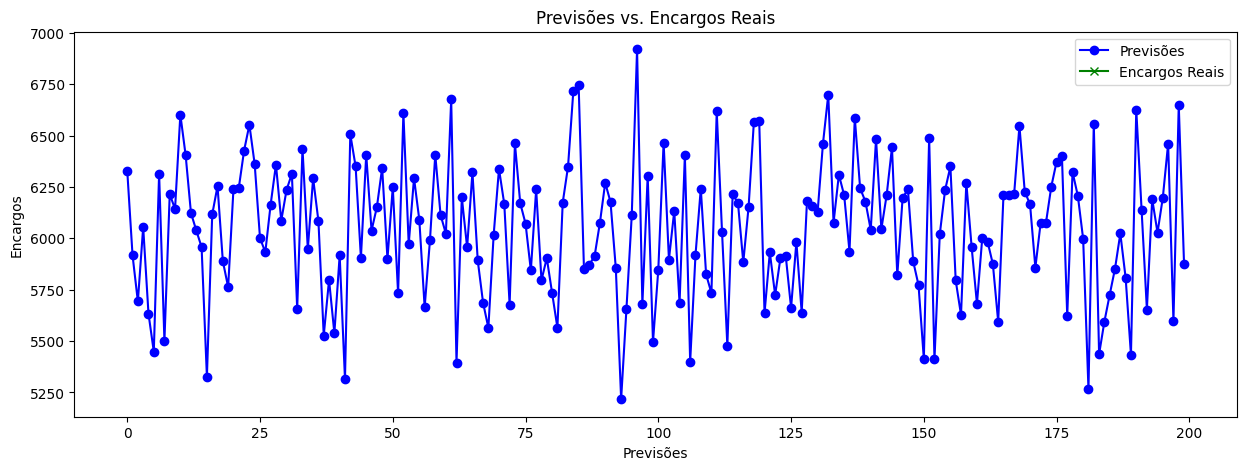

In [25]:
fig, axs = plt.subplots(figsize=(15, 5))

plt.plot(dados_futuros['Encargo Futuro'], label='Previsões', color='blue', marker='o')
plt.plot(dados_futuros['Encargos Reais'], label='Encargos Reais', color='green', marker='x')

plt.xlabel('Previsões')
plt.ylabel('Encargos')
plt.legend()
plt.title('Previsões vs. Encargos Reais')
plt.show()